In [3]:
# Install and Import Required Libraries
#!pip install spacy -q
!pip install textblob
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 5.6 MB/s eta 0:00:00
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 6.0 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
import spacy
import re
from collections import Counter
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from textblob import TextBlob

In [5]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [6]:
# load large SpaCy model
#nlp = spacy.load("en_core_web_lg")

## Basic NER SpaCy functions


In [7]:
# text example
text = "Apple is looking to buy U.K. startup for $1 billion"
doc = nlp(text)

In [8]:
# check all possible entity labels in your model
entity_labels = nlp.get_pipe("ner").labels
print("All entity labels available in this model:", entity_labels)

All entity labels available in this model: ('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


## Description of each entity label in spaCy:

CARDINAL: Numerals that don't fall under another type (like MONEY, DATE, etc.). Examples: "two", "twenty", "100".

DATE: Absolute or relative dates or periods. Examples: "January 2023", "yesterday", "last summer".

EVENT: Named events like hurricanes, wars, sports events. Examples: "World Cup", "Christmas", "Civil War".

FAC: Facilities, buildings, airports, highways, bridges. Examples: "Empire State Building", "JFK Airport", "Golden Gate Bridge".

GPE: Geo-political entities - countries, cities, states. Examples: "France", "New York City", "California".

LANGUAGE: Named languages. Examples: "Spanish", "Japanese", "ASL".

LAW: Named documents made into laws. Examples: "Constitution", "Bill of Rights", "GDPR".

LOC: Non-GPE locations, mountain ranges, bodies of water. Examples: "Himalayan Mountains", "Atlantic Ocean", "the South Pole".

MONEY: Monetary values, including unit. Examples: "$100", "10 euros", "5 dollars".

NORP: Nationalities, religious or political groups. Examples: "Americans", "Christians", "Republicans".

ORDINAL: Ordinal numbers. Examples: "first", "second", "10th".

ORG: Companies, agencies, institutions. Examples: "Microsoft", "FBI", "University of Michigan".

PERCENT: Percentage values. Examples: "10%", "twenty percent", "10 percentage points".

PERSON: People, including fictional characters. Examples: "Barack Obama", "Harry Potter", "Taylor Swift".

PRODUCT: Objects, vehicles, foods, etc. (not services). Examples: "iPhone", "Boeing 747", "Pepsi".

QUANTITY: Measurements with units. Examples: "10km", "50 feet", "200lbs".

TIME: Times of day, not including dates. Examples: "3pm", "noon", "midnight".

WORK_OF_ART: Titles of books, songs, movies, etc. Examples: "The Great Gatsby", "Bohemian Rhapsody", "Star Wars".

In [9]:
# Iterate through entities and print their labels
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}, Label Description: {spacy.explain(ent.label_)}")


Entity: Apple, Label: ORG, Label Description: Companies, agencies, institutions, etc.
Entity: U.K., Label: GPE, Label Description: Countries, cities, states
Entity: $1 billion, Label: MONEY, Label Description: Monetary values, including unit


In [10]:
# Visualize entities in a document
from spacy import displacy
displacy.render(doc, style="ent")

In [11]:
# Get all unique entity labels in the text
unique_labels = set([ent.label_ for ent in doc.ents])
print("Unique entity labels in this document:", unique_labels)


Unique entity labels in this document: {'GPE', 'ORG', 'MONEY'}


#NER Applications in Data Engineering

# 1. Basic Log Analysis

In [12]:
def analyze_log(log_text):
    """Extract important information from log entries"""
    doc = nlp(log_text)

    # Extract entities
    entities = {
        'systems': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
        'dates': [ent.text for ent in doc.ents if ent.label_ == 'DATE'],
        'error_mentioned': 'error' in log_text.lower()
    }

    return entities

In [13]:
# Test log analysis
sample_log = """
Server1 reported error on January 23, 2024.
Database backup completed on MainSystem.
"""

log_results = analyze_log(sample_log)
print("Log Analysis Results:", log_results)


Log Analysis Results: {'systems': [], 'dates': ['January 23, 2024'], 'error_mentioned': True}


## Log Analysis
**Objective**: Analyze system logs to identify patterns, issues, and security concerns.

In [14]:
def analyze_logs(log_text):
    """Analyze system logs using spaCy and regex patterns"""
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(log_text)

    # Initialize patterns
    timestamp_pattern = r'\[(.*?)\]'
    ip_pattern = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'
    level_pattern = r'INFO|ERROR|WARNING|CRITICAL'

    # Extract basic information
    log_entries = []

    for line in log_text.split('\n'):
        if line.strip():
            # Extract timestamp
            timestamp_match = re.search(timestamp_pattern, line)
            timestamp = timestamp_match.group(1) if timestamp_match else None

            # Extract log level
            level_match = re.search(level_pattern, line)
            level = level_match.group(0) if level_match else None

            # Extract IPs
            ips = re.findall(ip_pattern, line)

            # Process with spaCy for entity recognition
            doc_line = nlp(line)

            entry = {
                'timestamp': timestamp,
                'level': level,
                'ips': ips,
                'systems': [ent.text for ent in doc_line.ents if ent.label_ == 'ORG'],
                'message': line.split('] ')[-1] if '] ' in line else line
            }
            log_entries.append(entry)

    # Analyze patterns
    error_count = Counter([entry['level'] for entry in log_entries])
    system_mentions = Counter([system for entry in log_entries
                             for system in entry['systems']])
    ip_addresses = [ip for entry in log_entries for ip in entry['ips']]

    return {
        'entries': log_entries,
        'statistics': {
            'error_levels': dict(error_count),
            'system_mentions': dict(system_mentions),
            'unique_ips': list(set(ip_addresses))
        }
    }



In [15]:
# function to visualize the log analysis
def visualize_log_analysis(analysis):
    """Create visualizations for log analysis"""
    # Error levels distribution
    plt.figure(figsize=(10, 5))
    error_levels = analysis['statistics']['error_levels']
    plt.bar(error_levels.keys(), error_levels.values())
    plt.title('Distribution of Log Levels')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # System mentions
    plt.figure(figsize=(12, 5))
    system_mentions = analysis['statistics']['system_mentions']
    plt.bar(system_mentions.keys(), system_mentions.values())
    plt.title('System Mentions Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
# Test the analysis
sample_logs = """
[2024-01-24 08:00:15] INFO - MainServer1 startup completed successfully. System health check passed.
[2024-01-24 08:15:22] ERROR - Database01 connection failed at 192.168.1.100. Retry attempt 1 initiated.
[2024-01-24 08:15:30] WARNING - High CPU usage detected on AppServer2 (85%). Memory utilization: 75%.
[2024-01-24 08:16:05] ERROR - Database01 connection failed at 192.168.1.100. Retry attempt 2 initiated.
[2024-01-24 08:20:45] INFO - Backup process started on StorageServer3. Target: /mnt/backup/daily.
[2024-01-24 08:25:10] ERROR - SecurityModule detected unauthorized access attempt from IP 203.0.113.45.
"""

In [17]:
# Run analysis
results = analyze_logs(sample_logs)

In [18]:
# Print results
print("Log Analysis Results:\n")
print("Error Level Distribution:")
for level, count in results['statistics']['error_levels'].items():
    print(f"{level}: {count}")

print("\nUnique IP Addresses:")
for ip in results['statistics']['unique_ips']:
    print(ip)

print("\nSystem Mentions:")
for system, count in results['statistics']['system_mentions'].items():
    print(f"{system}: {count}")


Log Analysis Results:

Error Level Distribution:
INFO: 2
ERROR: 3

Unique IP Addresses:
203.0.113.45
192.168.1.100

System Mentions:
CPU: 1
INFO - Backup: 1
Target: 1
IP: 1


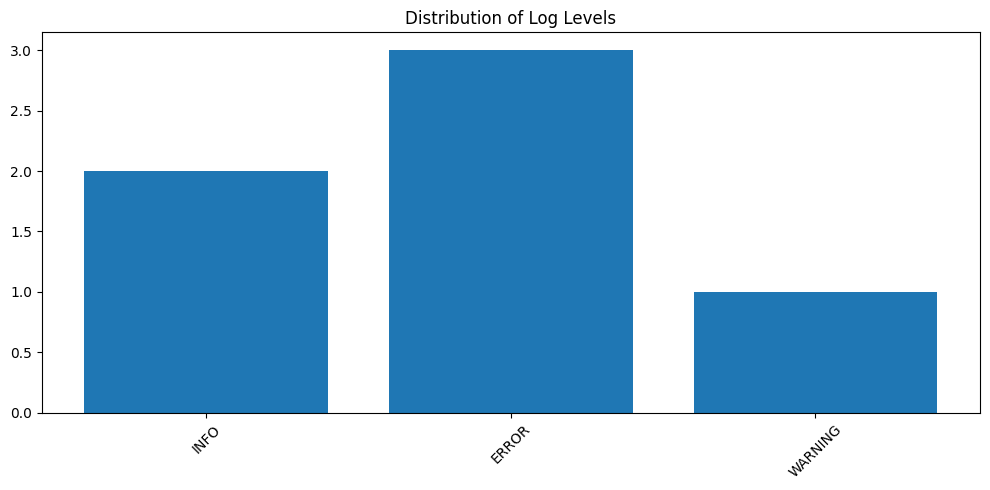

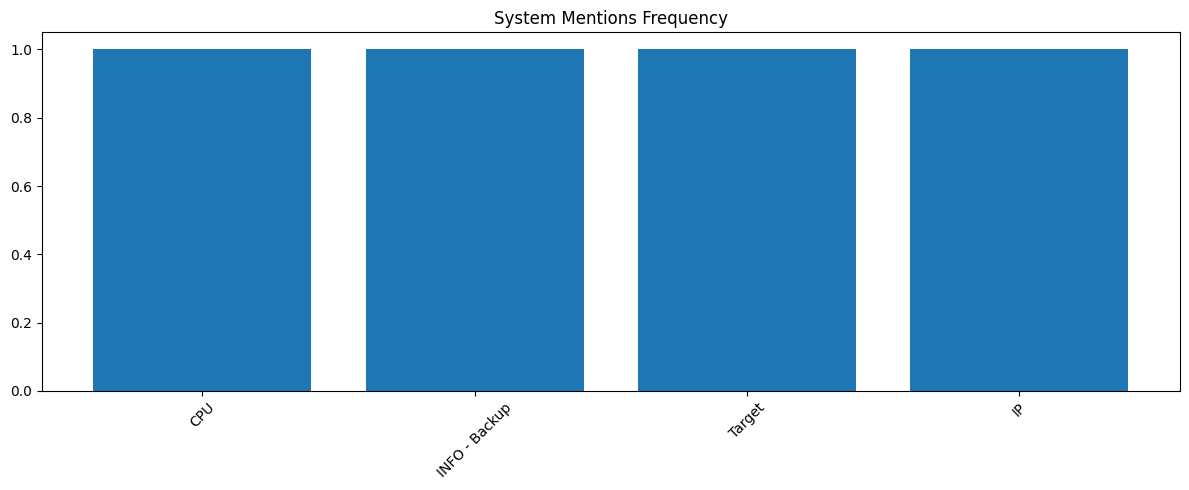

In [19]:
# Visualize results
visualize_log_analysis(results)


In [20]:
# Create timeline of critical events
critical_events = [entry for entry in results['entries']
                  if entry['level'] in ['ERROR', 'CRITICAL']]
print("\nCritical Events Timeline:")
for event in critical_events:
    print(f"{event['timestamp']} - {event['message']}")


Critical Events Timeline:
2024-01-24 08:15:22 - ERROR - Database01 connection failed at 192.168.1.100. Retry attempt 1 initiated.
2024-01-24 08:16:05 - ERROR - Database01 connection failed at 192.168.1.100. Retry attempt 2 initiated.
2024-01-24 08:25:10 - ERROR - SecurityModule detected unauthorized access attempt from IP 203.0.113.45.


## 2. Simple Customer Feedback Analysis

In [21]:
def analyze_feedback(feedback_text):
    """Analyze customer feedback for products and features"""
    doc = nlp(feedback_text)

    analysis = {
        'products': [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT'],
        'companies': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
        'features_mentioned': [token.text for token in doc if token.pos_ == 'NOUN']
    }

    return analysis

In [22]:
# Test feedback analysis
feedback = """
The new iPhone camera is amazing but the battery life needs improvement.
Apple should focus on battery technology.
"""

In [23]:
feedback_results = analyze_feedback(feedback)
print("\nFeedback Analysis Results:", feedback_results)


Feedback Analysis Results: {'products': [], 'companies': ['Apple'], 'features_mentioned': ['camera', 'battery', 'life', 'improvement', 'battery', 'technology']}


# Customer Feedback Analysis with NER

 We'll extract products, features, and sentiment from customer reviews using spaCy and TextBlob.

## Key Features
- Product identification
- Feature extraction
- Sentiment analysis (TextBlob)
- Key phrase detection

## Use Cases
- Product improvement insights
- Customer satisfaction monitoring
- Feature prioritization
- Competitive analysis



In [24]:
def analyze_customer_feedback(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    # Custom product and feature lists
    products = ["iPhone", "iPad", "MacBook", "Galaxy", "Pixel", "Surface"]
    features = ["camera", "battery", "screen", "display", "speaker", "performance",
               "speed", "design", "weight", "price", "storage"]

    analysis = {
        'products': [token.text for token in doc if token.text in products],
        'features': [token.text for token in doc if token.text in features],
        'sentiment': TextBlob(text).sentiment.polarity,
        'nouns': [chunk.text for chunk in doc.noun_chunks]
    }

    return analysis


In [25]:
# Test cases
feedback_samples = [
    """The iPhone 14's camera is amazing! Battery life could be better though.""",

    """Not happy with my new Pixel's screen brightness. The speaker quality is great
    but the battery drains too fast.""",

    """MacBook performance is outstanding, but the price is too high. Love the design and weight though.""",

    """The Galaxy's display is beautiful. Camera needs improvement,
    especially in low light. Storage space is sufficient."""
]

In [26]:
for i, feedback in enumerate(feedback_samples, 1):
    result = analyze_customer_feedback(feedback)
    print(f"\nFeedback {i} Analysis:")
    print(f"Products: {result['products']}")
    print(f"Features: {result['features']}")
    print(f"Sentiment: {result['sentiment']:.2f}")
    print(f"Key phrases: {result['nouns']}")



Feedback 1 Analysis:
Products: ['iPhone']
Features: ['camera']
Sentiment: 0.62
Key phrases: ["The iPhone 14's camera", 'Battery life']

Feedback 2 Analysis:
Products: ['Pixel']
Features: ['screen', 'speaker', 'battery']
Sentiment: 0.18
Key phrases: ["my new Pixel's screen brightness", 'The speaker quality', 'the battery']

Feedback 3 Analysis:
Products: ['MacBook']
Features: ['performance', 'price', 'design', 'weight']
Sentiment: 0.39
Key phrases: ['MacBook performance', 'the price', 'the design', 'weight']

Feedback 4 Analysis:
Products: ['Galaxy']
Features: ['display']
Sentiment: 0.42
Key phrases: ["The Galaxy's display", 'Camera', 'improvement', 'low light', 'Storage space']


# 3. Document Information Extraction

In [27]:
def extract_document_info(text):
    """Extract key information from documents"""
    doc = nlp(text)

    info = {
        'people': [ent.text for ent in doc.ents if ent.label_ == 'PERSON'],
        'organizations': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
        'locations': [ent.text for ent in doc.ents if ent.label_ == 'GPE'],
        'dates': [ent.text for ent in doc.ents if ent.label_ == 'DATE']
    }

    return info

In [28]:
# Test document analysis
document = """
John Smith from Microsoft presented at the conference in New York
on December 5, 2024. Google and Apple also attended the event.
"""

doc_results = extract_document_info(document)
print("\nDocument Analysis:", doc_results)


Document Analysis: {'people': ['John Smith'], 'organizations': ['Microsoft', 'Google', 'Apple'], 'locations': ['New York'], 'dates': ['December 5, 2024']}


In [29]:
# Visualization of Entity Distribution
def visualize_entities(text):
    """Create a simple visualization of entity types"""
    doc = nlp(text)
    entity_counts = Counter([ent.label_ for ent in doc.ents])

    # Convert to DataFrame for visualization
    df = pd.DataFrame.from_dict(entity_counts, orient='index', columns=['count'])
    df.plot(kind='bar', title='Entity Types Distribution')



Visualizing entities in the document:


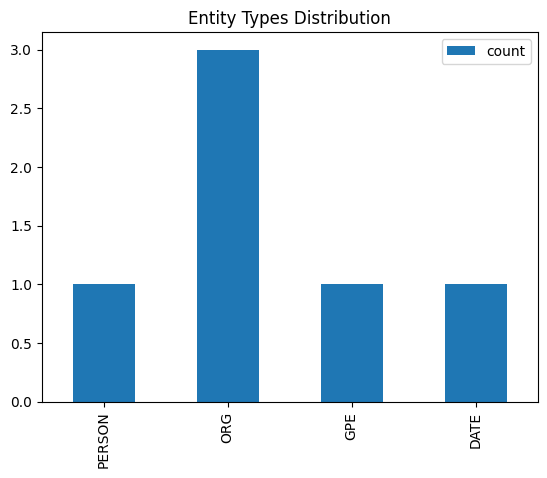

In [30]:
# Test visualization
print("\nVisualizing entities in the document:")
visualize_entities(document)

# 4. Summarize important entities

In [31]:
import spacy
from collections import Counter
from spacy.tokens import Doc

def summarize_important_entities(text: str) -> dict:
    """
    Generate a summary of important entities from text using frequency and context.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    # Count entity frequencies
    entity_freq = Counter([ent.text.lower() for ent in doc.ents])

    # Group entities by type
    entities_by_type = {}
    for ent in doc.ents:
        if ent.label_ not in entities_by_type:
            entities_by_type[ent.label_] = []
        entities_by_type[ent.label_].append(ent.text)

    # Find context for top entities
    top_entities = {}
    for ent, freq in entity_freq.most_common(5):
        contexts = []
        for sent in doc.sents:
            if ent in sent.text.lower():
                contexts.append(sent.text.strip())

        # Get entity type
        ent_type = next((e.label_ for e in doc.ents if e.text.lower() == ent), None)

        top_entities[ent] = {
            'frequency': freq,
            'type': ent_type,
            'contexts': contexts[:2]  # Limit to 2 example contexts
        }

    return {
        'top_entities': top_entities,
        'entities_by_type': entities_by_type,
        'total_entities': len(doc.ents)
    }

# Example usage
text = """
Apple Inc. announced new AI features today. The company's CEO Tim Cook presented
the features at Apple's headquarters in Cupertino. Google and Microsoft have also
been expanding their AI capabilities. Tim Cook emphasized Apple's commitment to
privacy in AI development. The presentation in Cupertino showcased several new
Apple products.
"""

summary = summarize_important_entities(text)

print("Top Entities:")
for entity, details in summary['top_entities'].items():
    print(f"\nEntity: {entity}")
    print(f"Type: {details['type']}")
    print(f"Frequency: {details['frequency']}")
    print("Example contexts:")
    for context in details['contexts']:
        print(f"- {context}")

print("\nEntities by Type:")
for type_, entities in summary['entities_by_type'].items():
    print(f"{type_}: {', '.join(set(entities))}")

print(f"\nTotal entities found: {summary['total_entities']}")

Top Entities:

Entity: ai
Type: ORG
Frequency: 3
Example contexts:
- Apple Inc. announced new AI features today.
- Google and Microsoft have also
been expanding their AI capabilities.

Entity: apple
Type: ORG
Frequency: 3
Example contexts:
- Apple Inc. announced new AI features today.
- The company's CEO Tim Cook presented
the features at Apple's headquarters in Cupertino.

Entity: tim cook
Type: PERSON
Frequency: 2
Example contexts:
- The company's CEO Tim Cook presented
the features at Apple's headquarters in Cupertino.
- Tim Cook emphasized Apple's commitment to
privacy in AI development.

Entity: cupertino
Type: GPE
Frequency: 2
Example contexts:
- The company's CEO Tim Cook presented
the features at Apple's headquarters in Cupertino.
- The presentation in Cupertino showcased several new
Apple products.

Entity: apple inc.
Type: ORG
Frequency: 1
Example contexts:
- Apple Inc. announced new AI features today.

Entities by Type:
ORG: Microsoft, Google, Apple, AI, Apple Inc.
DATE: tod

#Task: Medical Named Entity Recognition Challenge
Task: Create a system to analyze medical records and extract key information:

1. Basic Task:
- Extract all healthcare providers (doctors)
- Extract medical facilities
- Extract dates of visits/procedures
- Print these in a clear format

2. Intermediate Task:
- Identify medications and their dosages
- Extract medical conditions/diagnoses
- Track measurements (like HbA1c, blood pressure)



Sample medical records are provided below. Test your code with these and create your own examples.


**Sample medical records for testing**




In [32]:
test_records = [
    """
    Initial Visit - 01/15/2024
    Dr. James Wilson at City Hospital performed initial consultation.
    Patient presents with frequent headaches and high blood pressure (150/90).
    Prescribed Amlodipine 5mg daily.
    """,

    """
    Follow-up - 02/28/2024
    Dr. Sarah Lee at Medical Center reviewed progress.
    BP improved to 130/85. Headaches reduced.
    Continue Amlodipine 5mg, added Vitamin D 2000IU.
    Referred to Dr. Chen at Neurology Clinic.
    """
]